## Dataset

In [1]:
import os
import pickle
import numpy as np
from env.env import PICK_TARGETS, PLACE_TARGETS, PickPlaceEnv

import matplotlib.pyplot as plt
import clip
import torch
from clipport.model import TransporterNets, n_params
from clipport.train import train_step, eval_step
from clipport.run import run_cliport
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn
from flax.training import checkpoints
from flax.metrics import tensorboard


pybullet build time: Mar  1 2023 12:07:22


In [2]:
env  = PickPlaceEnv()

In [3]:
#@markdown Collect demonstrations with a scripted expert, or download a pre-generated dataset.
load_pregenerated = True  #@param {type:"boolean"}

# Load pre-existing dataset.
if not os.path.exists('dataset-9999.pkl'):
    # !gdown --id 1TECwTIfawxkRYbzlAey0z1mqXKcyfPc-
    !gdown --id 1yCz6C-6eLWb4SFYKdkM-wz5tlMjbG2h8
dataset = pickle.load(open('dataset-9999.pkl', 'rb'))  # ~10K samples.
dataset_size = len(dataset['text'])


# pickle.dump(dataset, open(f'dataset-{dataset_size}.pkl', 'wb'))

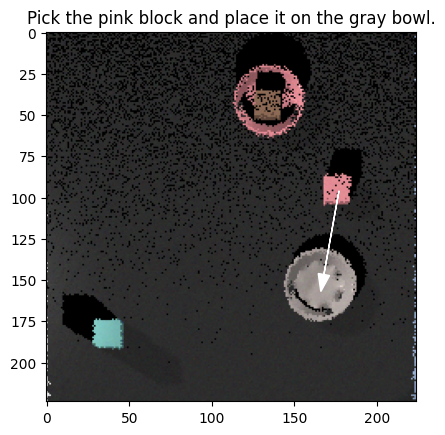

In [4]:
#@markdown Show a demonstration example from the dataset.
idx = 20
img = dataset['image'][idx]
pick_yx = dataset['pick_yx'][idx]
place_yx = dataset['place_yx'][idx]
text = dataset['text'][idx]
plt.title(text)
plt.imshow(img)
plt.arrow(pick_yx[1], pick_yx[0], place_yx[1]-pick_yx[1], place_yx[0]-pick_yx[0], color='w', head_starts_at_zero=False, head_width=7, length_includes_head=True)
plt.show()

In [4]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [7]:
# Precompute CLIP features for all text in training dataset.
text_tokens = clip.tokenize(dataset['text']).cuda()
text_i = 0
data_text_feats = np.zeros((0, 512), dtype=np.float32)
while text_i < len(text_tokens):
  batch_size = min(len(text_tokens) - text_i, 512)
  text_batch = text_tokens[text_i:text_i+batch_size]
  with torch.no_grad():
    batch_feats = clip_model.encode_text(text_batch).float()
  batch_feats /= batch_feats.norm(dim=-1, keepdim=True)
  batch_feats = np.float32(batch_feats.cpu())
  data_text_feats = np.concatenate((data_text_feats, batch_feats), axis=0)
  text_i += batch_size

In [8]:
import datetime
name = datetime.datetime.now().strftime(f'%Y-%m-%d-%H:%M:%S-cliport')
logdir = os.path.join("logs", name)
writer = tensorboard.SummaryWriter(logdir)
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


## Train

In [7]:
# Coordinate map (i.e. position encoding).
coord_x, coord_y = np.meshgrid(np.linspace(-1, 1, 224), np.linspace(-1, 1, 224), sparse=False, indexing='ij')
coords = np.concatenate((coord_x[..., None], coord_y[..., None]), axis=2)

In [10]:
load_pretrained = True  #@param {type:"boolean"}

# Initialize model weights using dummy tensors.
rng = jax.random.PRNGKey(0)
rng, key = jax.random.split(rng)
init_img = jnp.ones((4, 224, 224, 5), jnp.float32)
init_text = jnp.ones((4, 512), jnp.float32)
init_pix = jnp.zeros((4, 2), np.int32)
init_params = TransporterNets().init(key, init_img, init_text, init_pix)['params']
print(f'Model parameters: {n_params(init_params):,}')
optim = flax.optim.Adam(learning_rate=1e-4).create(init_params)

if load_pretrained:
  ckpt_path = f'ckpt_{40000}'
  if not os.path.exists(ckpt_path):
    !gdown --id 1Nq0q1KbqHOA5O7aRSu4u7-u27EMMXqgP
  optim = checkpoints.restore_checkpoint(ckpt_path, optim)
  print('Loaded:', ckpt_path)
else:

  # Training loop.
  batch_size = 8
  for train_iter in range(1, 40001):
    batch_i = np.random.randint(dataset_size, size=batch_size)
    text_feat = data_text_feats[batch_i, ...]
    img = dataset['image'][batch_i, ...] / 255
    img = np.concatenate((img, np.broadcast_to(coords[None, ...], (batch_size,) + coords.shape)), axis=3)

    # Get onehot label maps.
    pick_yx = np.zeros((batch_size, 2), dtype=np.int32)
    pick_onehot = np.zeros((batch_size, 224, 224), dtype=np.float32)
    place_onehot = np.zeros((batch_size, 224, 224), dtype=np.float32)
    for i in range(len(batch_i)):
      pick_y, pick_x  = dataset['pick_yx'][batch_i[i], :]
      place_y, place_x = dataset['place_yx'][batch_i[i], :]
      pick_onehot[i, pick_y, pick_x] = 1
      place_onehot[i, place_y, place_x] = 1
      # pick_onehot[i, ...] = scipy.ndimage.gaussian_filter(pick_onehot[i, ...], sigma=3)

      # Data augmentation (random translation).
      roll_y, roll_x = np.random.randint(-112, 112, size=2)
      img[i, ...] = np.roll(img[i, ...], roll_y, axis=0)
      img[i, ...] = np.roll(img[i, ...], roll_x, axis=1)
      pick_onehot[i, ...] = np.roll(pick_onehot[i, ...], roll_y, axis=0)
      pick_onehot[i, ...] = np.roll(pick_onehot[i, ...], roll_x, axis=1)
      place_onehot[i, ...] = np.roll(place_onehot[i, ...], roll_y, axis=0)
      place_onehot[i, ...] = np.roll(place_onehot[i, ...], roll_x, axis=1)
      pick_yx[i, 0] = pick_y + roll_y
      pick_yx[i, 1] = pick_x + roll_x

    # Backpropagate.
    batch = {}
    batch['img'] = jnp.float32(img)
    batch['text'] = jnp.float32(text_feat)
    batch['pick_yx'] = jnp.int32(pick_yx)
    batch['pick_onehot'] = jnp.float32(pick_onehot)
    batch['place_onehot'] = jnp.float32(place_onehot)
    rng, batch['rng'] = jax.random.split(rng)
    optim, loss, _, _ = train_step(optim, batch)
    writer.scalar('train/loss', loss, train_iter)

    if train_iter % np.power(10, min(4, np.floor(np.log10(train_iter)))) == 0:
      print(f'Train Step: {train_iter} Loss: {loss}')
    
    if train_iter % 1000 == 0:
      checkpoints.save_checkpoint('.', optim, train_iter, prefix='ckpt_', keep=100000, overwrite=True)

  warnings.warn(



Model parameters: 4,259,095
/home/rilab/.pyenv/versions/bullet/lib/python3.8/site-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Nq0q1KbqHOA5O7aRSu4u7-u27EMMXqgP
To: /home/rilab/lm_unct/ckpt_40000
100%|██████████████████████████████████████| 51.1M/51.1M [00:03<00:00, 13.8MB/s]
Loaded: ckpt_40000


## Run

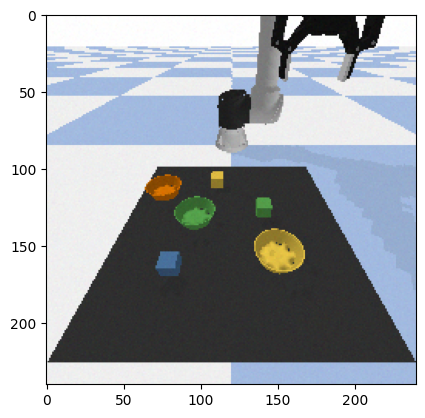

In [8]:
# Define and reset environment.
config = {'pick':  ['yellow block', 'green block', 'blue block'],
          'place': ['yellow bowl', 'green bowl', 'orange bowl']}

np.random.seed(42)
obs = env.reset(config)
img = env.get_camera_image()
plt.imshow(img)
plt.show()

In [9]:
user_input = 'Pick the yellow block and place it on the orange bowl.'  #@param {type:"string"}

# pick_xyz, place_xyz, pick_map, place_map, pick_yx, place_yx = 
obs = run_cliport(env,clip_model,coords, optim, obs, user_input)


NameError: name 'optim' is not defined